<a href="https://colab.research.google.com/github/danielhou13/cogs402longformer/blob/main/src/ConvertSlidingAttentionMatrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we convert the longformer model's sliding attention matrix into a traditional seq_len x seq_len attention matrix. The longformer's attention output is a tensor of shape: (layer, batch, head, seq_len, x+attention_window+1). The x is the number of tokens that you have with global attention. We wish to convert it into a tensor of shape: (layer, batch, head, seq_len, seq_len). We then visualize the attention matrix by creating a 2d heatmap.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import and Install Dependencies

In [ ]:
# import sys
# sys.path.append('/content/drive/My Drive/{}'.format("cogs402longformer/"))

In [ ]:
pip install transformers --quiet

     |████████████████████████████████| 4.4 MB 4.3 MB/s 
     |████████████████████████████████| 6.6 MB 67.3 MB/s 
     |████████████████████████████████| 596 kB 68.7 MB/s 
     |████████████████████████████████| 101 kB 14.0 MB/s 


In [ ]:
pip install captum --quiet

     |████████████████████████████████| 1.4 MB 4.1 MB/s 


In [ ]:
pip install datasets --quiet

     |████████████████████████████████| 362 kB 4.1 MB/s 
     |████████████████████████████████| 1.1 MB 78.2 MB/s 
     |████████████████████████████████| 140 kB 79.7 MB/s 
     |████████████████████████████████| 212 kB 72.6 MB/s 
     |████████████████████████████████| 127 kB 60.1 MB/s 
     |████████████████████████████████| 271 kB 56.3 MB/s 
     |████████████████████████████████| 144 kB 71.4 MB/s 
     |████████████████████████████████| 94 kB 3.8 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

###Import Dataset

In [ ]:
from datasets import load_dataset
cogs402_ds = load_dataset("danielhou13/cogs402dataset")["test"]
cogs402_ds2 = load_dataset("danielhou13/cogs402dataset2")['validation']

Downloading:   0%|          | 0.00/739 [00:00<?, ?B/s]

Using custom data configuration danielhou13--cogs402dataset-144b958ac1a53abb


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/danielhou13___parquet/danielhou13--cogs402dataset-144b958ac1a53abb/0.0.0/7328ef7ee03eaf3f86ae40594d46a1cec86161704e02dd19f232d81eee72ade8. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/2.26k [00:00<?, ?B/s]

Using custom data configuration danielhou13--cogs402dataset2-52067477e0d49a06


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/danielhou13___parquet/danielhou13--cogs402dataset2-52067477e0d49a06/0.0.0/7328ef7ee03eaf3f86ae40594d46a1cec86161704e02dd19f232d81eee72ade8. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

### Import Model

Here we are importing the model and tokenizer and sneding our model to GPU. Please change the model_path and tokenizer to one fitting your own project.

In [ ]:
from transformers import LongformerForSequenceClassification, LongformerTokenizer, LongformerConfig
# replace <PATH-TO-SAVED-MODEL> with the real path of the saved model
model_path = 'danielhou13/longformer-finetuned_papers_v2'
model_path2 = 'danielhou13/longformer-finetuned-news-cogs402'

# load model
model = LongformerForSequenceClassification.from_pretrained(model_path, num_labels = 2)
model.to(device)
model.eval()
model.zero_grad()

# load tokenizer
tokenizer = LongformerTokenizer.from_pretrained("allenai/longformer-base-4096")

Downloading:   0%|          | 0.00/0.99k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/567M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/694 [00:00<?, ?B/s]

### Getting the Attentions

We want the model's attentions and global attentions as we are trying to create a complete seq_len x seq_len attention matrix.

In [ ]:
def predict(inputs, position_ids=None, attention_mask=None):
    output = model(inputs,
                   position_ids=position_ids,
                   attention_mask=attention_mask,
                   output_attentions = True)
    return output.logits, output.attentions, output.global_attentions

It isn't necessary to do it this way, as you can also tokenizer and get the model's outputs in a more traditional matter. These replicate the longformer model's implementation for obtaining input_ids, position_ids and attention_mask.

In [ ]:
ref_token_id = tokenizer.pad_token_id # A token used for generating token reference
sep_token_id = tokenizer.sep_token_id # A token used as a separator between question and text and it is also added to the end of the text.
cls_token_id = tokenizer.cls_token_id # A token used for prepending to the concatenated question-text word sequence

In [ ]:
def construct_input(text, sep_token_id, cls_token_id):

    text_ids = tokenizer.encode(text, truncation = True, add_special_tokens=False, max_length = 2046)
    # construct input token ids
    input_ids = [cls_token_id] + text_ids + [sep_token_id]

    return torch.tensor([input_ids], device=device), len(text_ids)

def construct_input_ref_pos_id_pair(input_ids):
    #taken from the longformer implementation
    mask = input_ids.ne(ref_token_id).int()
    incremental_indices = torch.cumsum(mask, dim=1).type_as(mask) * mask
    position_ids = incremental_indices.long().squeeze() + ref_token_id
    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)

    return position_ids

def construct_attention_mask(input_ids):
    return torch.ones_like(input_ids)

In [ ]:
if torch.__version__ >= '1.7.0':
    norm_fn = torch.linalg.norm
else:
    norm_fn = torch.norm

We can select any example you desire by changing the testval to an example you know is interesting. Alternative you can set it to a random example in your dataset.

In [ ]:
testval = 976
text = cogs402_ds['text'][testval]
label = cogs402_ds['labels'][testval]
print(label)

0


Here we apply the functions we created above to get the input_ids, position_ids and the attention_mask.

In [ ]:
input_ids, sep_id = construct_input(text, sep_token_id, cls_token_id)

position_ids = construct_input_ref_pos_id_pair(input_ids)
attention_mask = construct_attention_mask(input_ids)

indices = input_ids[0].detach().tolist()
all_tokens = tokenizer.convert_ids_to_tokens(indices)

In [ ]:
print(input_ids.squeeze().shape)

torch.Size([2048])


Here we do our forward pass to get the attention, and global attention. The score isn't needed but it is a required output from the model, so we have to create a variable for it.

In [ ]:
score, attention, global_attention = predict(input_ids, position_ids, attention_mask)

### Converting our Attention Matrix

These functions simply fits our attention outputs into the tensor of shape: (layer, batch, head, seq_len, x+attention_window+1) that we will convert into the traditional attention shape.

In [ ]:
# shape -> layer x batch x head x seq_len x attention_window
output_attentions_all = torch.stack(attention).cpu()

global_attention_all = torch.stack(global_attention).cpu()

In [ ]:
print(output_attentions_all.device)
print(global_attention_all.device)

cpu
cpu


These are the functions we use to convert our sliding attention matrix into the seq_len x seq_len matrix. 

The first function `create_head_matrix` takes in a tensor of shape: (seq_len, x+attention_matrix+1) and outputs a tensor of shape: (seq_len, seq_len), which is the traditional attention shape that we want. 

The second function `attentions_all_heads` applies the first function for every head in the attention matrix. As such, it takes in a tensor of shape (head, seq_len, x+attention_matix+1) and outputs a tensor of shape: (head, seq_len, seq_len).

The third function `all_batches` applies the second function for every batch in the attention matrix. As such, it takes in a tensor of shape (batch, head, seq_len, x+attention_matix+1) and outputs a tensor of shape: (batch, head, seq_len, seq_len). 

The final function `all_layers` applies the second function for every batch in the attention matrix. As such, it takes in a tensor of shape (layer, batch, head, seq_len, x+attention_matix+1) and outputs a tensor of shape: (layer, batch, head, seq_len, seq_len). 

In [ ]:
def create_head_matrix(output_attentions, global_attentions):
  new_attention_matrix = torch.zeros((output_attentions.shape[0], 
                                      output_attentions.shape[0]))
  for i in range(output_attentions.shape[0]):
    test_non_zeroes = torch.nonzero(output_attentions[i]).squeeze()
    test2 = output_attentions[i][test_non_zeroes[1:]]
    new_attention_matrix_indices = test_non_zeroes[1:]-257 + i
    new_attention_matrix[i][new_attention_matrix_indices] = test2
    new_attention_matrix[i][0] = output_attentions[i][0]
    new_attention_matrix[0] = global_attentions.squeeze()[:output_attentions.shape[0]]
  return new_attention_matrix


def attentions_all_heads(output_attentions, global_attentions):
    new_matrix = []
    for i in range(output_attentions.shape[0]):
      matrix = create_head_matrix(output_attentions[i], global_attentions[i])
      new_matrix.append(matrix)
    return torch.stack(new_matrix)

def all_batches(output_attentions, global_attentions):
    new_matrix = []
    for i in range(output_attentions.shape[0]):
      matrix = attentions_all_heads(output_attentions[i], global_attentions[i])
      new_matrix.append(matrix)
    return torch.stack(new_matrix)

def all_layers(output_attentions, global_attentions):
    new_matrix = []
    for i in range(output_attentions.shape[0]):
      matrix = all_batches(output_attentions[i], global_attentions[i])
      new_matrix.append(matrix)
    return torch.stack(new_matrix)

2048
2048
torch.Size([2048])


Here we are doing a few tests to make sure that our code works. We can use the appropriate function to pass in a specific head an a specific layer. When we pick a specific layer, batch and head, we see that our resulting matrix is the appropriate seq_len x seq_len shape. Passing in the entire attention to the `all_layers` function produces the correct (layer, batch, head, seq_len, seq_len) matrix.

In [ ]:
test = output_attentions_all[11,0,11]
global_test = global_attention_all[11,0,11]

print(len(all_tokens))
print(test.shape[0])

print(global_test.squeeze().shape)

In [ ]:
new_matrix = create_head_matrix(test, global_test)
# new_matrix2 = attentions_all_heads(output_attentions_all[11][0], 
#                                    global_attention_all[11][0])
# new_matrix3 = all_batches(output_attentions_all[11], 
#                           global_attention_all[11])
new_matrix4 = all_layers(output_attentions_all, 
                         global_attention_all)
print(new_matrix)
# print(new_matrix2.shape)
# print(new_matrix3.shape)
print(new_matrix4.shape)

tensor([[7.3000e-03, 3.0835e-05, 5.5837e-03,  ..., 1.3681e-05, 3.9796e-06,
         5.7786e-05],
        [5.4646e-04, 6.0992e-02, 2.5319e-04,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.3526e-02, 7.0507e-05, 5.9212e-02,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [1.5974e-05, 0.0000e+00, 0.0000e+00,  ..., 6.2146e-03, 6.6250e-04,
         3.6403e-04],
        [3.8823e-04, 0.0000e+00, 0.0000e+00,  ..., 1.0985e-02, 5.6840e-02,
         2.4745e-02],
        [3.7118e-04, 0.0000e+00, 0.0000e+00,  ..., 1.7339e-03, 1.4356e-03,
         4.0184e-03]], grad_fn=<CopySlices>)
torch.Size([12, 1, 12, 2048, 2048])


In [ ]:
print(new_matrix.shape)

torch.Size([2048, 2048])


### Visualizing the attention

Using the following function slightly modified from [captum's visualization tutorial for BERT](https://captum.ai/tutorials/Bert_SQUAD_Interpret2), we can get the attention patterns for either a particular head in a given layer, or all the heads in a layer.

In [ ]:
def visualize_token2token_scores(scores_mat, x_label_name='Head'):
    fig = plt.figure(figsize=(45, 45))

    for idx, scores in enumerate(scores_mat):
        scores_np = np.array(scores)
        ax = fig.add_subplot(4, 3, idx+1)
        # append the attention weights
        im = ax.imshow(scores, cmap='cividis')

        fontdict = {'fontsize': 10}

        # ax.set_xticks(range(len(all_tokens)))
        # ax.set_yticks(range(len(all_tokens)))

        # ax.set_xticklabels(all_tokens, rotation=90)
        # ax.set_yticklabels(all_tokens, fontdict=fontdict)
        ax.set_xlabel('{} {}'.format(x_label_name, idx+1))
        ax.set_aspect('equal')
        fig.colorbar(im, fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()
  
def visualize_token2token_onehead(scores_mat, head_num):
    fig, ax = plt.subplots()
    fig.set_figheight(40)
    fig.set_figwidth(40)
    scores_np = np.array(scores_mat[head_num-1])
    print(scores_np.shape)
    c = ax.imshow(scores_np, cmap= 'cividis')
    fontdict = {'fontsize': 10}
    # ax.set_xticks(range(len(all_tokens)))
    # ax.set_yticks(range(len(all_tokens)))
    # ax.set_xticklabels(all_tokens, rotation=80)
    # ax.set_yticklabels(all_tokens, fontdict=fontdict)

    ax.set_xlabel('{} {}'.format("Head", head_num))

    plt.colorbar(c, fraction=0.046, pad=0.04)
    plt.show()

In [ ]:
layer=11

Here we are visualizing the attention matrix for layer 12, head 12.

(2048, 2048)


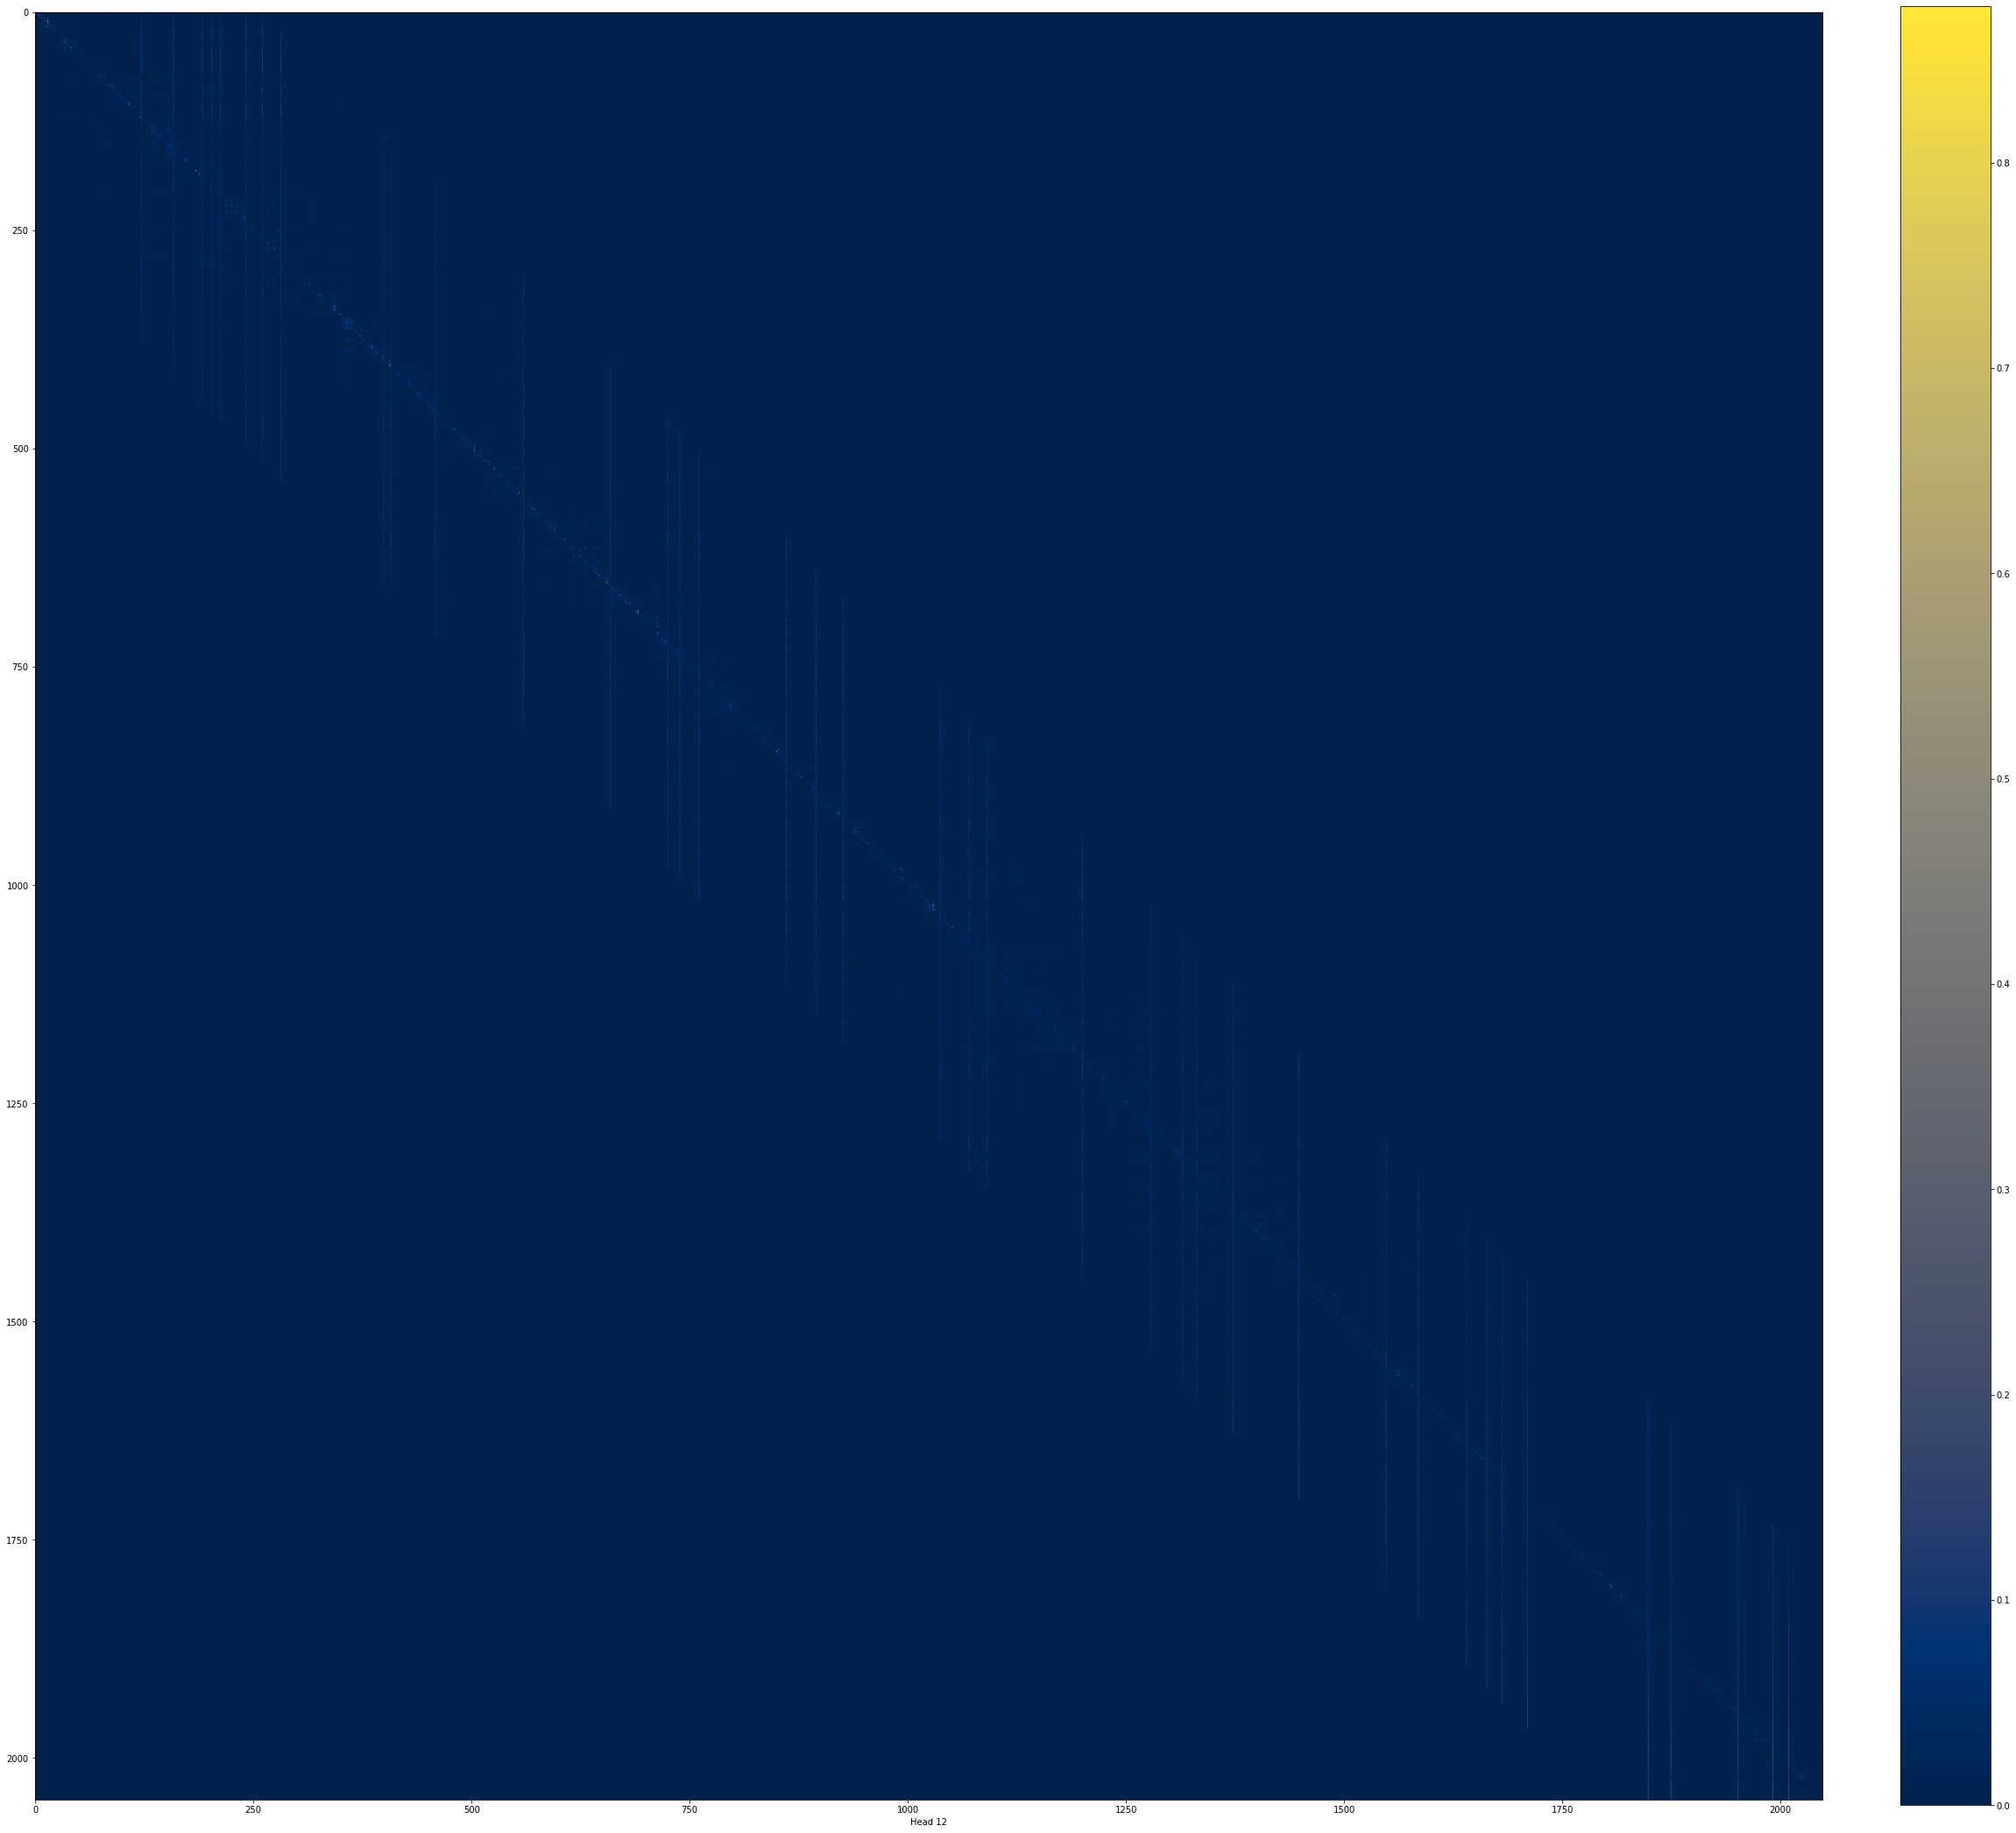

In [ ]:
visualize_token2token_onehead(new_matrix4[layer].squeeze().detach().cpu().numpy(), 12)

Here we are visualizing all of the attention heads for layer 12.

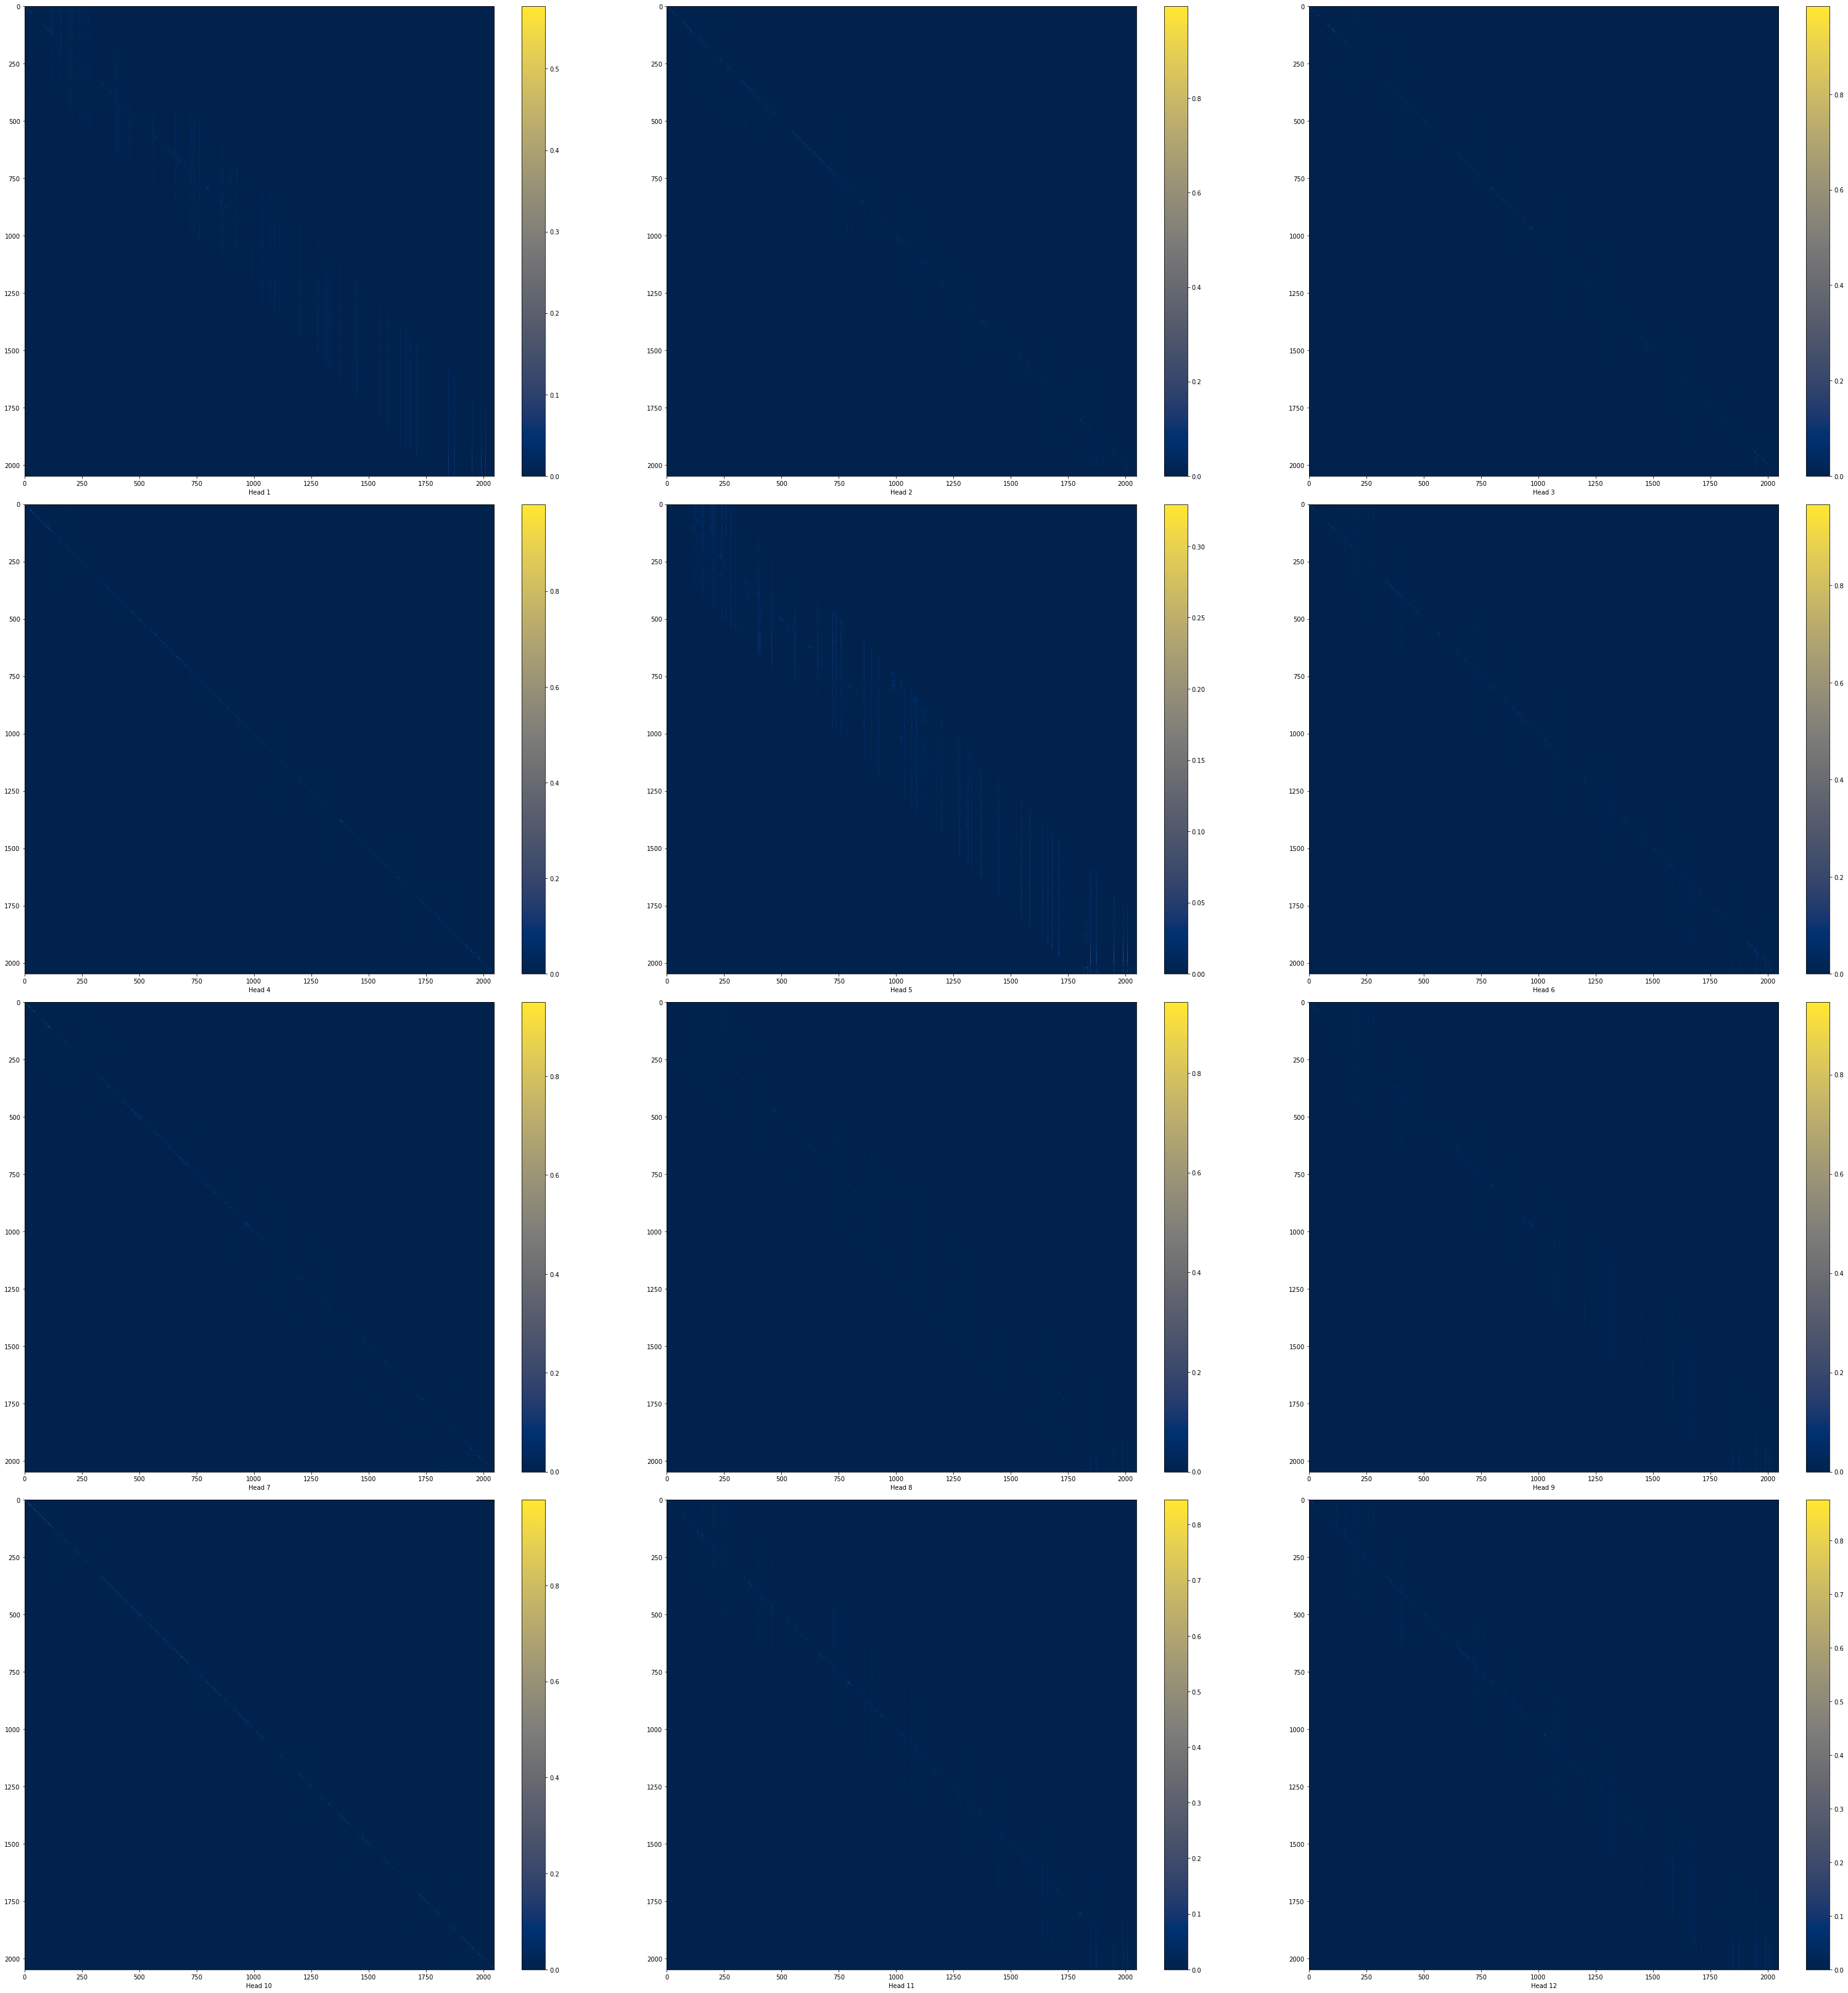

In [ ]:
visualize_token2token_scores(new_matrix4[layer].squeeze().detach().cpu().numpy())

Additionally, we can visualize the attentions for all layers by normalizing the attentions over all of the heads. This gives us a summary of the attention over all of the heads.

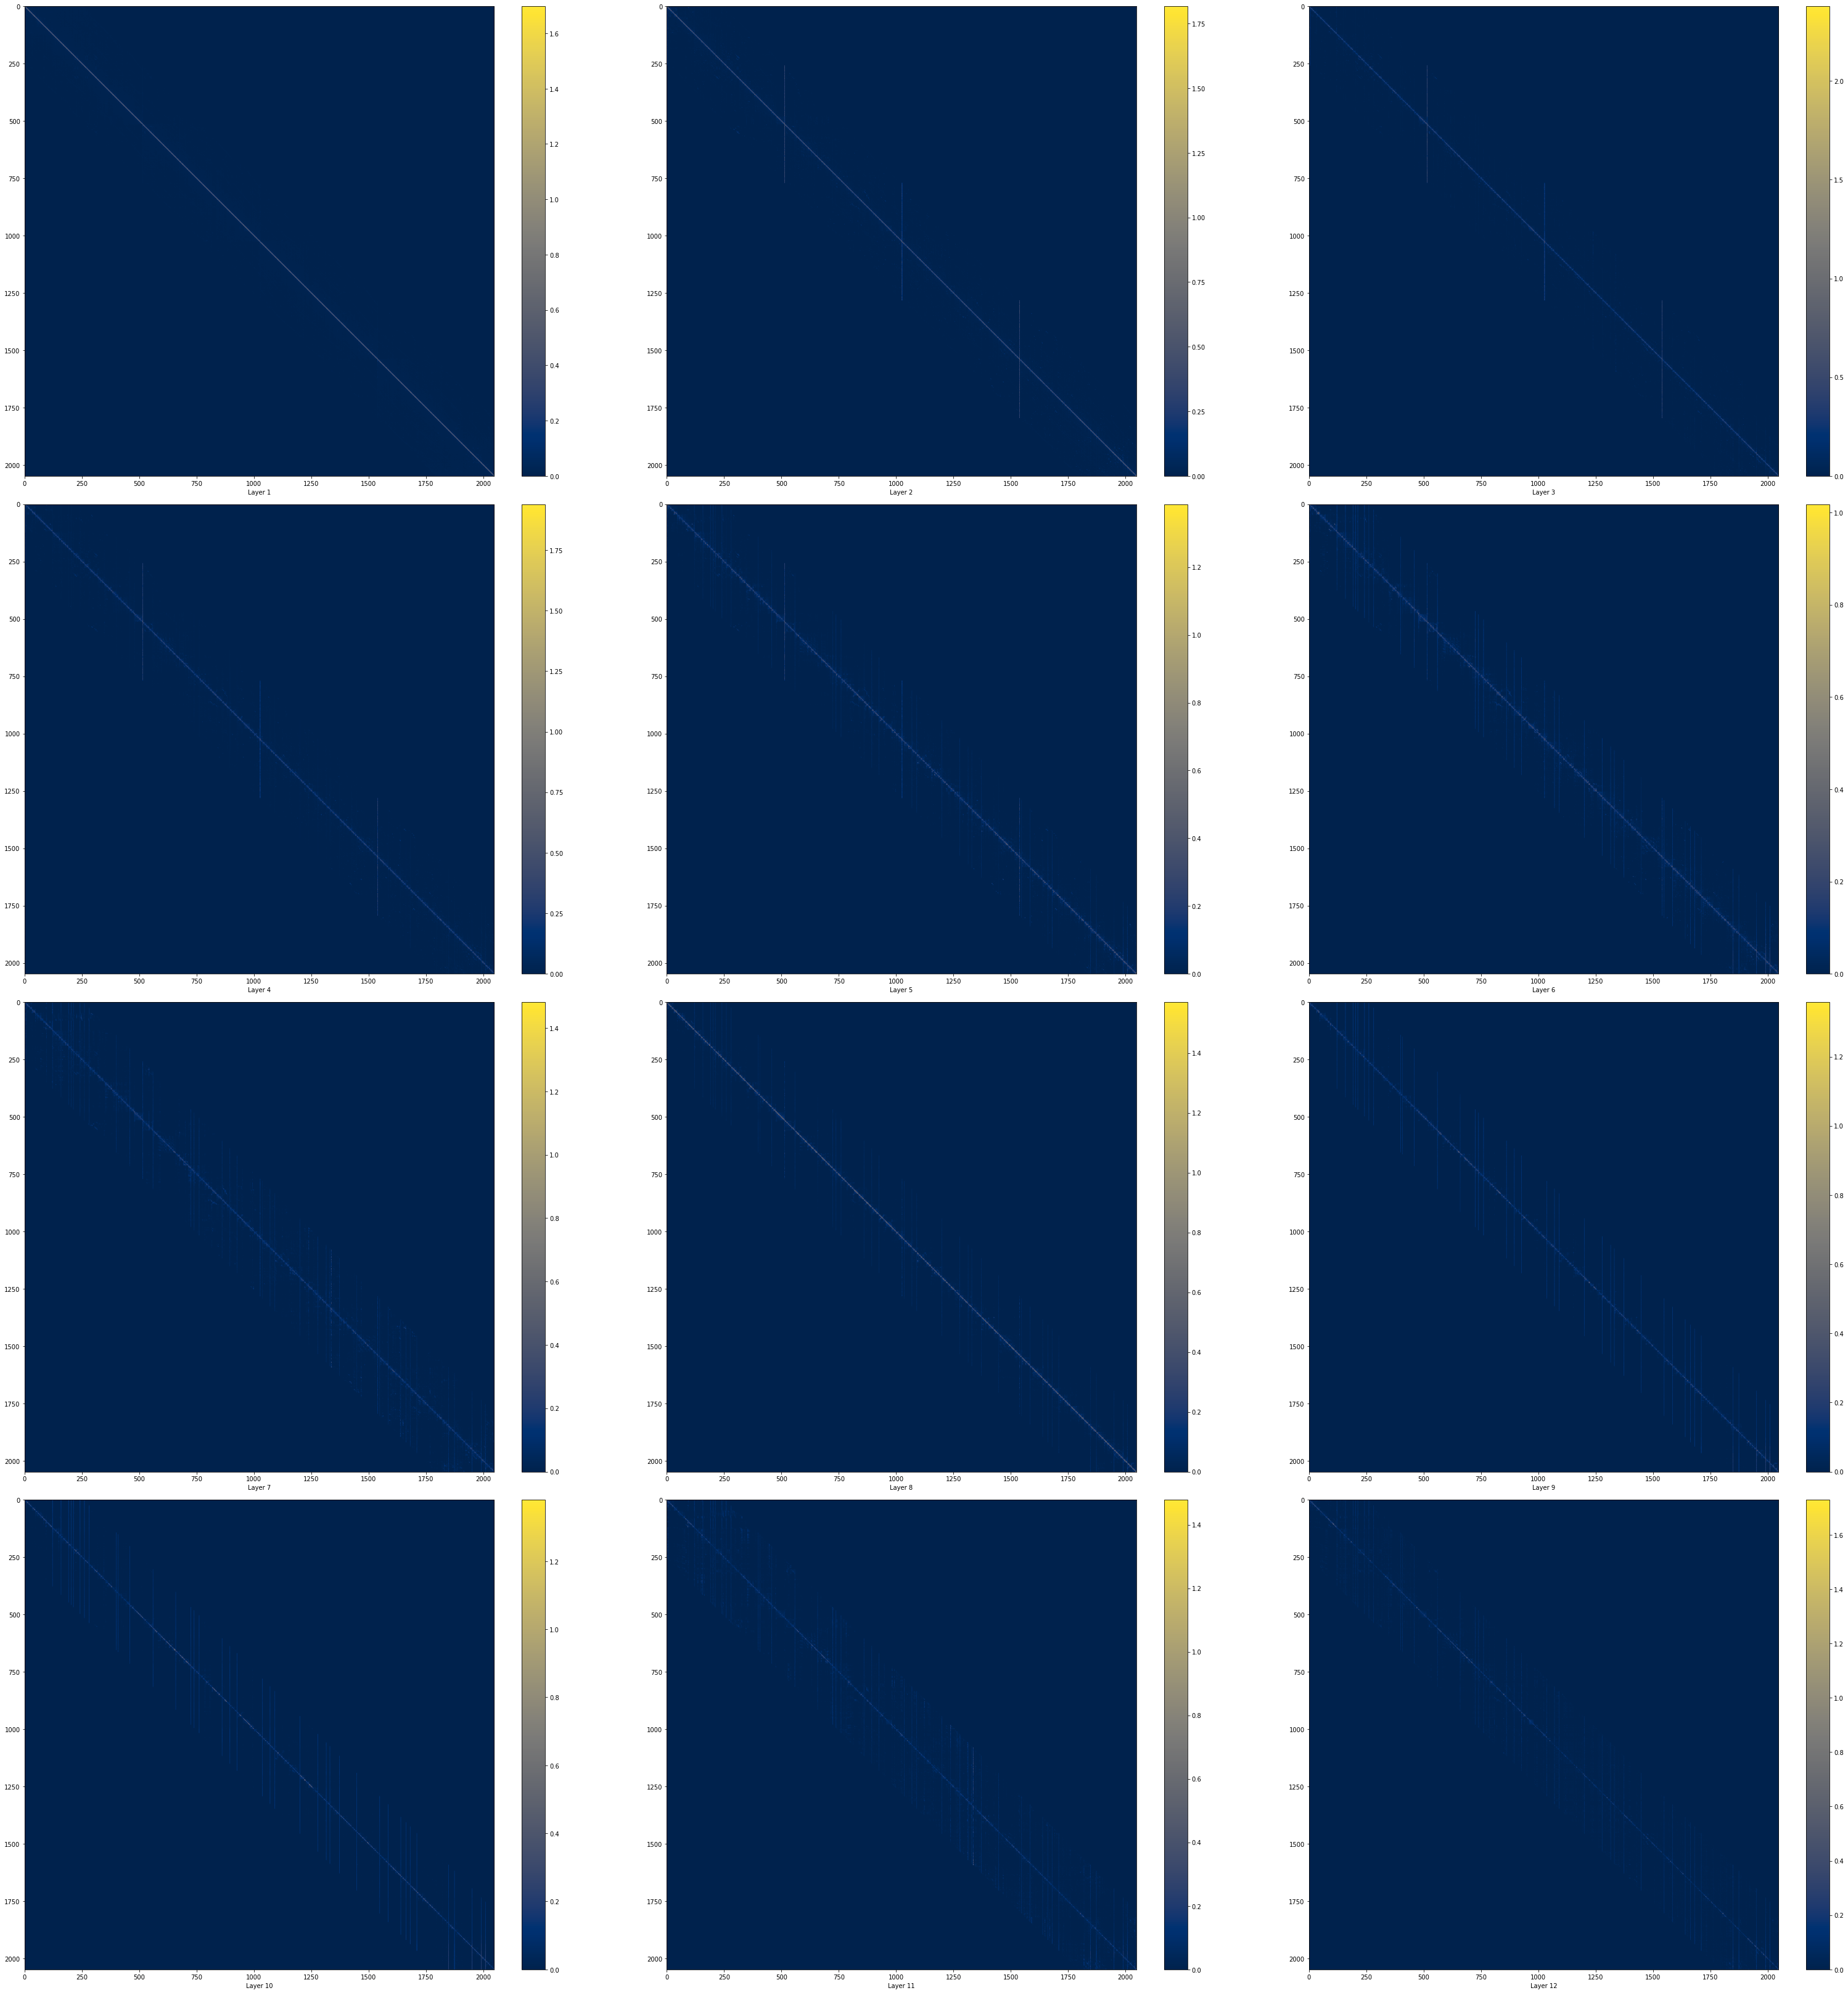

In [ ]:
visualize_token2token_scores(norm_fn(new_matrix4, dim=2).squeeze().detach().cpu().numpy(),
                             x_label_name='Layer')